In [2]:
!ls /kaggle/input/facenet-pytorch-wheel
!pip install --no-deps /kaggle/input/facenet-pytorch-wheel/facenet_pytorch-2.6.0-py3-none-any.whl
from facenet_pytorch import MTCNN, InceptionResnetV1
print("✅ facenet-pytorch berhasil diimport")

facenet_pytorch-2.6.0-py3-none-any.whl
Processing /kaggle/input/facenet-pytorch-wheel/facenet_pytorch-2.6.0-py3-none-any.whl
✅ facenet-pytorch berhasil diimport


In [3]:
import os
import json
import shutil

# Path dataset sample
base_path = "/kaggle/input/deepfake-detection-challenge"
train_videos_path = os.path.join(base_path, "train_sample_videos")
metadata_path = os.path.join(train_videos_path, "metadata.json")

# Output folder
output_dir = "/kaggle/working/train_sample_split"
os.makedirs(os.path.join(output_dir, "REAL"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "FAKE"), exist_ok=True)

# Baca metadata
with open(metadata_path, "r") as f:
    metadata = json.load(f)

# Pisahkan video berdasarkan label
for filename, info in metadata.items():
    label = info["label"]  # "REAL" atau "FAKE"
    src = os.path.join(train_videos_path, filename)
    dst = os.path.join(output_dir, label, filename)
    if os.path.exists(src):
        shutil.copy(src, dst)

print("✅ Selesai dipisahkan!")
print("REAL:", len(os.listdir(os.path.join(output_dir, "REAL"))))
print("FAKE:", len(os.listdir(os.path.join(output_dir, "FAKE"))))


✅ Selesai dipisahkan!
REAL: 77
FAKE: 323


Preparing DFDC dataset...


Processing FAKE videos: 100%|██████████| 323/323 [56:07<00:00, 10.43s/it]
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test set size: 1547 samples
✅ Model Celeb-DF v2 berhasil diload, siap diuji di DFDC


Evaluating DFDC: 100%|██████████| 49/49 [00:07<00:00,  6.85it/s]



--- DFDC Evaluation ---
              precision    recall  f1-score   support

        REAL       0.22      0.88      0.35       304
        FAKE       0.88      0.23      0.37      1243

    accuracy                           0.36      1547
   macro avg       0.55      0.55      0.36      1547
weighted avg       0.75      0.36      0.37      1547



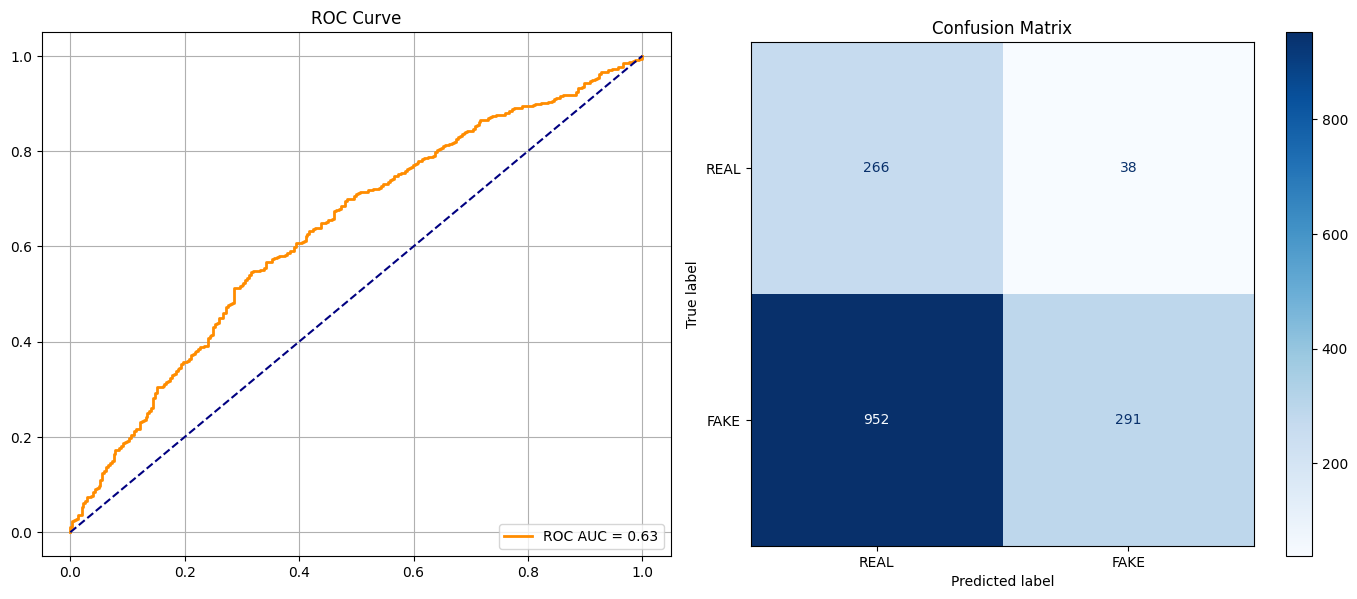

In [4]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# --- New Dependencies ---
# You need to install them:
# pip install facenet-pytorch
# pip install scikit-image
# pip install timm
from facenet_pytorch import MTCNN
from skimage.feature import local_binary_pattern
import timm # PyTorch Image Models library for Xception

# --- Configuration ---
CONFIG = {
    "real_data_path": "/kaggle/working/train_sample_split/REAL",
    "fake_data_path": "/kaggle/working/train_sample_split/FAKE",
    "max_videos_per_class": 1000, 
    "frames_per_video": 20,       
    "image_size": 224,
    "batch_size": 32,            
    "epochs": 30,
    "learning_rate": 1e-4,
    "seed": 42,
    "model_name": "xception",    # recommended by the paper
    "model_save_path": "./model_checkpoints_lbp",
    "early_stopping_patience": 5,
    "weight_decay": 1e-5,
}

# Set seed for reproducibility
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Step 1: Face Detection + LBP Preprocessing ---
mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=20, device=device)

def apply_gaussian_and_lbp(image):
    """Apply Gaussian Blur + Local Binary Pattern (LBP)."""
    img_np_gray = np.array(image.convert('L'))
    img_blur = cv2.GaussianBlur(img_np_gray, (3, 3), 0)

    lbp = local_binary_pattern(img_blur, 24, 3, method='uniform')
    lbp = (lbp / np.max(lbp) * 255).astype(np.uint8)
    lbp_rgb = cv2.cvtColor(lbp, cv2.COLOR_GRAY2RGB)

    return Image.fromarray(lbp_rgb)

def prepare_frames_dataset(config):
    """Load DFDC videos → frames → face detect → LBP preprocessing."""
    print("Preparing DFDC dataset...")
    all_images, all_labels = [], []

    def process_videos(video_paths, label, desc):
        for video_path in tqdm(video_paths, desc=desc):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                continue

            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_indices = np.linspace(0, frame_count - 1, config["frames_per_video"], dtype=int)

            for i in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    continue

                frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                face_tensor = mtcnn(frame_pil)

                if face_tensor is not None:
                    face_pil = transforms.ToPILImage()(face_tensor)
                    lbp_image = apply_gaussian_and_lbp(face_pil)
                    all_images.append(lbp_image)
                    all_labels.append(label)

            cap.release()

    real_videos = [os.path.join(config["real_data_path"], f) for f in os.listdir(config["real_data_path"])][:config["max_videos_per_class"]]
    fake_videos = [os.path.join(config["fake_data_path"], f) for f in os.listdir(config["fake_data_path"])][:config["max_videos_per_class"]]

    process_videos(real_videos, 0, "Processing REAL videos")
    process_videos(fake_videos, 1, "Processing FAKE videos")

    # train/val/test split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        all_images, all_labels, test_size=0.20, random_state=config["seed"], stratify=all_labels
    )

    return X_test, y_test  # karena hanya evaluasi → ambil test saja

# --- Step 2: PyTorch Dataset ---
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.transform(self.images[idx]), torch.tensor(self.labels[idx], dtype=torch.long)
# --- Step 3: Load Pretrained Model Celeb-DF v2 ---

def get_model(model_name, num_classes=2):
    return timm.create_model(model_name, pretrained=False, num_classes=num_classes)
# --- Step 4: Evaluation Function ---

def evaluate_on_test_set(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating DFDC"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n--- DFDC Evaluation ---")
    print(classification_report(all_labels, all_preds, target_names=['REAL', 'FAKE']))

    plt.figure(figsize=(14, 6))
    # ROC
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'FAKE'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
# --- Step 5: Main Execution---

if __name__ == "__main__":
    # Prepare DFDC test dataset
    X_test, y_test = prepare_frames_dataset(CONFIG)
    print(f"Test set size: {len(X_test)} samples")

    # Transform
    data_transforms = transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
    test_dataset = ImageDataset(X_test, y_test, data_transforms)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

    # Load Celeb-DF model
    model = get_model(CONFIG["model_name"]).to(device)
    model.load_state_dict(torch.load("/kaggle/input/model-celebdf-pth/model_celebdf.pth", map_location=device))
    model.eval()
    print("✅ Model Celeb-DF v2 berhasil diload, siap diuji di DFDC")

    # Evaluate on DFDC
    evaluate_on_test_set(model, test_loader, device)

In [5]:
import torch
torch.save(model.state_dict(), "/kaggle/working/model_DFDC.pth")